# Health Insurance Data Analysis

This notebook provides a structured analysis of the health insurance dataset. We'll cover Exploratory Data Analysis (EDA), Regression Analysis, Classification Analysis.

### Introduction: 
The health insurance industry plays a pivotal role in the healthcare ecosystem, acting as an intermediary between healthcare providers and patients. Accurately predicting insurance claims can be of paramount importance to such companies, allowing them to set premiums appropriately, manage risks, and maintain profitability. The dataset under scrutiny offers a snapshot of various factors that could influence insurance claims, including age, BMI, number of children, smoking habits, and regular exercise routines. Through this analysis, we aim to uncover patterns, relationships, and insights that can guide insurance companies in their decision-making processes.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


## Exploratory Data Analysis (EDA)

In this section, we'll explore the dataset's distributions, relationships, and potential outliers.

In [2]:
# Load the data
data = pd.read_csv('health_insurance.csv')
data.head()

,age,sex,weight,bmi,hereditary_diseases,no_of_dependents,smoker,city,diabetes,regular_ex,job_title,claim,age_group,state
0,60,male,64,24.3,NoDisease,1,0,NewYork,0,0,Actor,13112.6,Seniors,New York
1,49,female,75,22.6,NoDisease,1,0,Boston,1,1,Engineer,9567.0,Middle-aged,Massachusetts
2,32,female,64,17.8,Epilepsy,2,1,Phildelphia,1,1,Academician,32734.2,Young Adults,Pennsylvania
3,61,female,53,36.4,NoDisease,1,1,Pittsburg,1,0,Chef,48517.6,Seniors,Pennsylvania
4,19,female,50,20.6,NoDisease,0,0,Buffalo,1,0,HomeMakers,1731.7,Young Adults,New York


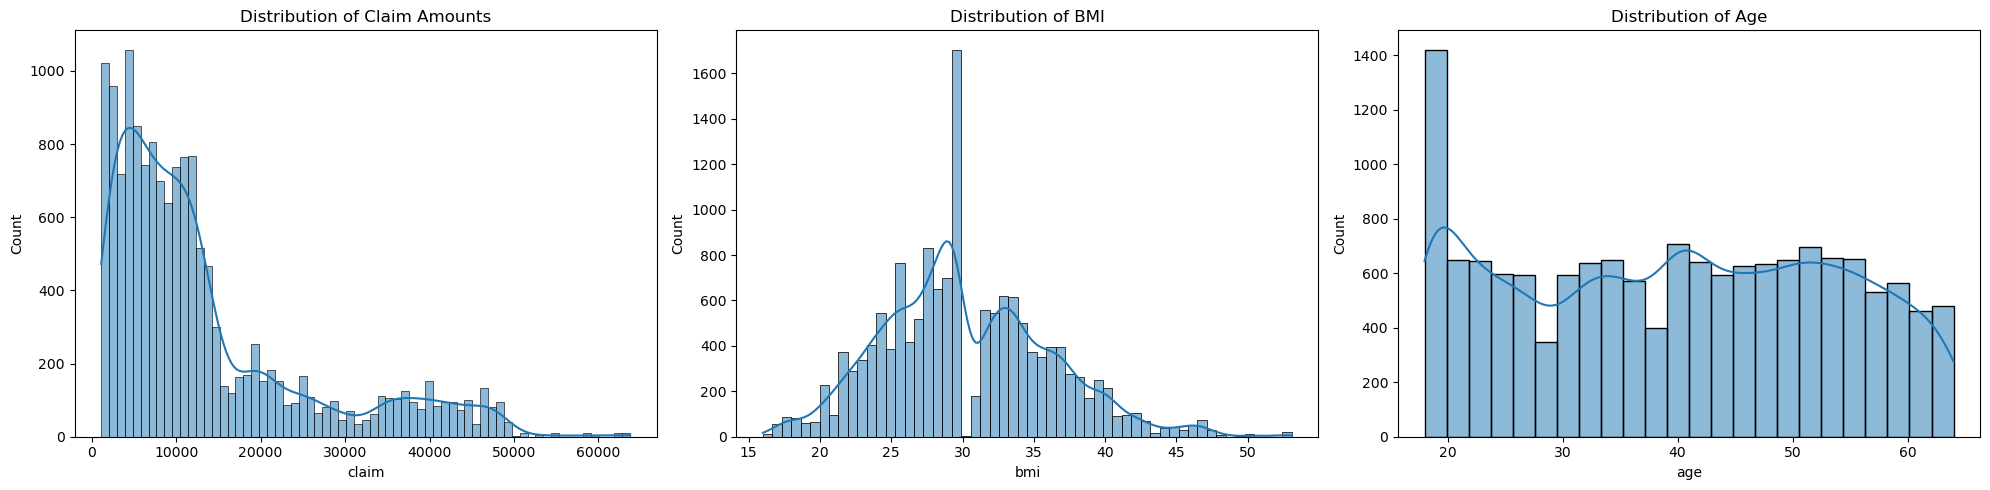

C:\Users\ttgmo\AppData\Local\Temp\ipykernel_9896\3467862294.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


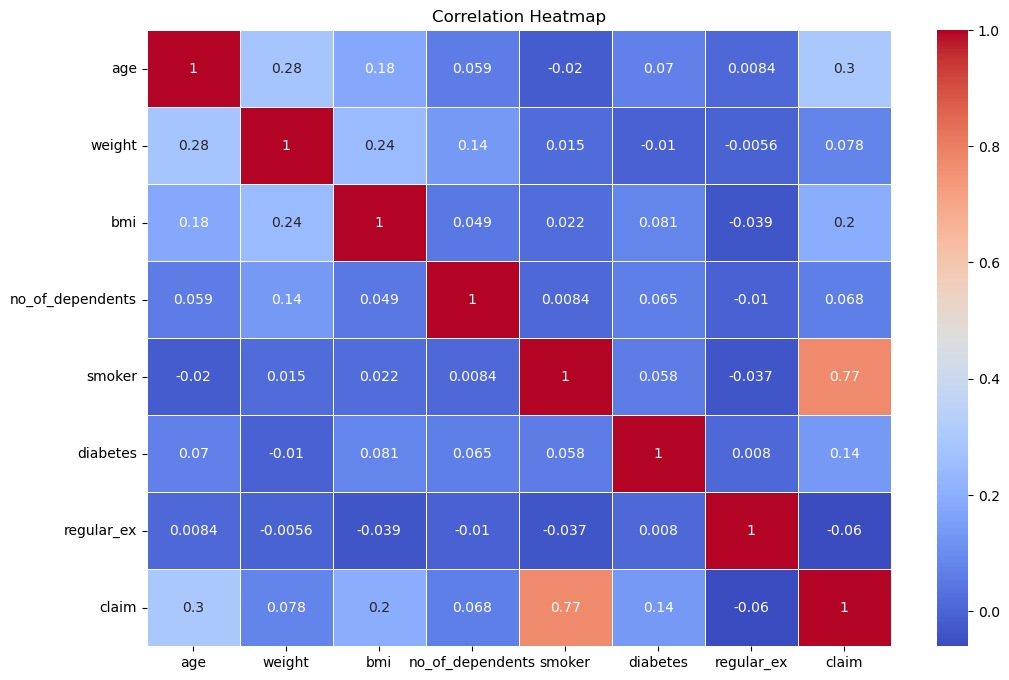

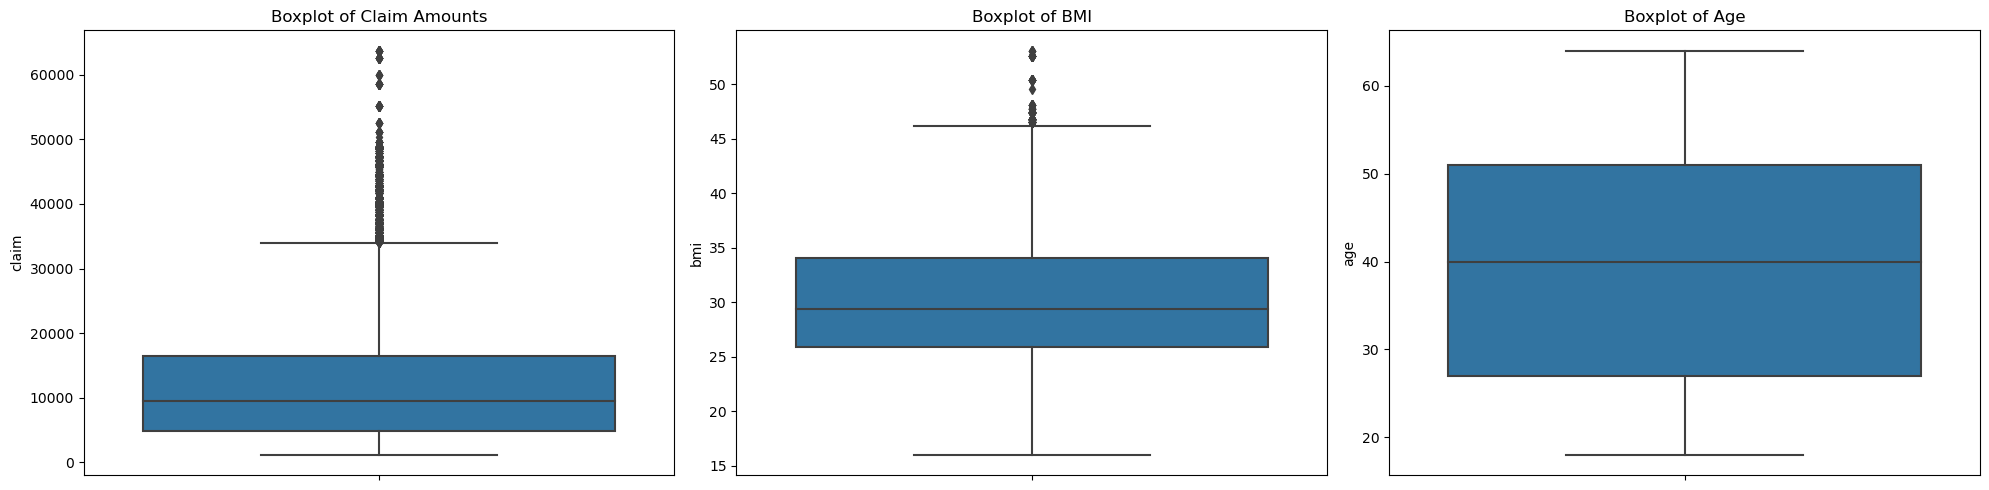

In [3]:
# Distribution of key variables
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(data['claim'], ax=ax[0], kde=True)
ax[0].set_title('Distribution of Claim Amounts')

sns.histplot(data['bmi'], ax=ax[1], kde=True)
ax[1].set_title('Distribution of BMI')

sns.histplot(data['age'], ax=ax[2], kde=True)
ax[2].set_title('Distribution of Age')

plt.tight_layout()
plt.show()

# Correlation heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Boxplots for key variables
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(y=data['claim'], ax=ax[0])
ax[0].set_title('Boxplot of Claim Amounts')

sns.boxplot(y=data['bmi'], ax=ax[1])
ax[1].set_title('Boxplot of BMI')

sns.boxplot(y=data['age'], ax=ax[2])
ax[2].set_title('Boxplot of Age')

plt.tight_layout()
plt.show()

The distribution of claim amounts, skewed to the right, reveals that while the majority of individuals have moderate medical expenses, a select few experience exceptionally high costs, potentially due to rare medical conditions or unique circumstances. This skewness, coupled with the presence of outliers, underscores the unpredictability and range of medical expenses. Outliers in the BMI distribution further highlight a subset of individuals with atypical health profiles, possibly due to distinct health conditions or lifestyles.

On the other hand, the balanced age distribution suggests a well-represented dataset across various age groups. The heatmap offers a pivotal insight: a pronounced positive correlation between smoking and claim amounts. This indicates that smokers, facing heightened health risks, consistently accrue more substantial medical expenses. Such a correlation emphasizes the profound financial implications of lifestyle choices on healthcare costs.

## Regression Analysis (Predict `claim`)

In [4]:
# Selected Features (based on the Random Forest's feature importance)
selected_features = ['smoker', 'age', 'bmi', 'hereditary_diseases', 'weight', 'diabetes', 'no_of_dependents']
selected_data = data[selected_features].copy()

# One-Hot Encoding for the categorical feature(s)
selected_data = pd.get_dummies(selected_data, drop_first=True)

In [5]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['age', 'bmi', 'weight', 'no_of_dependents']
selected_data[numerical_features] = scaler.fit_transform(selected_data[numerical_features])

X = selected_data
y = data['claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
def calculate_rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
# Model training and evaluation
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, seed=42)
}

rmsle_values = []
mae_values = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmsle_values.append(calculate_rmsle(y_test, preds))
    mae_values.append(mean_absolute_error(y_test, preds))


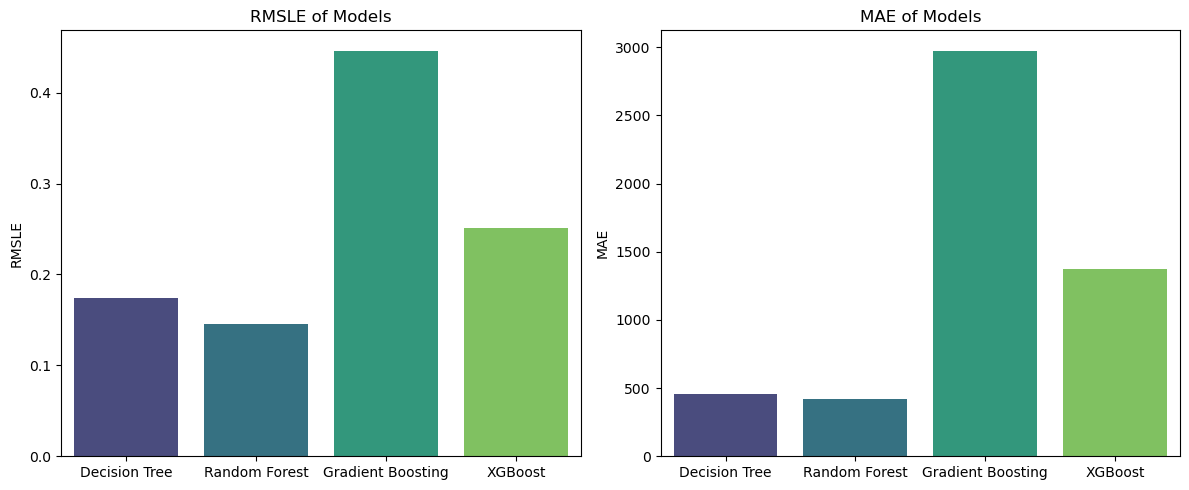

In [7]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=list(models.keys()), y=rmsle_values, palette="viridis")
plt.title('RMSLE of Models')
plt.ylabel('RMSLE')

plt.subplot(1, 2, 2)
sns.barplot(x=list(models.keys()), y=mae_values, palette="viridis")
plt.title('MAE of Models')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

The Random Forest model outperformed other models in predicting the insurance claims, excelling in both Mean Absolute Error (MAE) and Root Mean Squared Log Error (RMSLE) metrics for the regression classifier. This suggests that the Random Forest was more accurate and reliable in its predictions.

In [10]:
# Define the hyperparameters and their possible values for RandomizedSearchCV
random_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [5, 10, 20,30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForest and RandomizedSearchCV
rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                                  n_iter=50, cv=3, n_jobs=-1, verbose=2, 
                                  random_state=42, scoring='neg_mean_squared_error')

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params_random = random_search.best_params_

print(best_params_random)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [11]:
optimized_rf = RandomForestRegressor(
    n_estimators=50, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='sqrt', 
    max_depth=None, 
    random_state=42
)
optimized_rf.fit(X_train, y_train)
optimized_rf_preds = optimized_rf.predict(X_test)

# Calculate the performance metrics for the optimized Random Forest model
optimized_rf_rmsle = calculate_rmsle(y_test, optimized_rf_preds)
optimized_rf_mae = mean_absolute_error(y_test, optimized_rf_preds)

print("Optimized Random Forest RMSLE:", optimized_rf_rmsle)
print("Optimized Random Forest MAE:", optimized_rf_mae)

Optimized Random Forest RMSLE: 0.13360044889843622
Optimized Random Forest MAE: 409.5611018972454


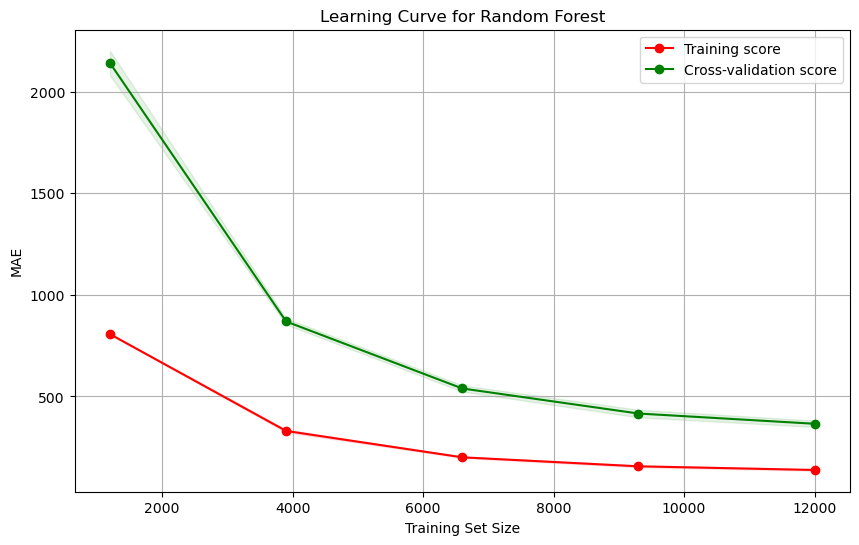

In [12]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    optimized_rf, X, y, cv=5, scoring="neg_mean_absolute_error", 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(-train_scores, axis=1)
train_std = np.std(-train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
test_mean = np.mean(-test_scores, axis=1)
test_std = np.std(-test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.legend(loc="best")
plt.title("Learning Curve for Random Forest")
plt.grid()
plt.show()

After selecting the Random Forest as the preferred model, I embarked on hyperparameter tuning to optimize its performance. For this, I utilized RandomizedSearchCV, which offers a more efficient approach than an exhaustive grid search. The search space spanned a broad range of parameters, and the process involved fitting 3 folds for each of the 50 candidates, totaling 150 fits.

The optimal parameters identified were:

n_estimators: 50
min_samples_split: 2
min_samples_leaf: 1
max_features: 'sqrt'
max_depth: None
Subsequently, I plotted a learning curve for the Random Forest model. This curve illuminated the model's performance as more data was fed into it. Notably, the test model's score, after cross-validation, was converging towards the score of the trained model. This suggests that as more data becomes available, the model's performance can potentially improve further.

It's crucial to highlight that while the model might display signs of overfitting with the given data, this doesn't necessarily translate to a consistent pattern across all contexts. Sometimes, specific datasets or scenarios might yield different behaviors, and it's essential to evaluate the model's generalizability case by case.

In [11]:
# Define the RMSLE calculation function
def calculate_rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Set up the Random Forest model with the best hyperparameters
optimized_rf = RandomForestRegressor(
    n_estimators=100, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='sqrt', 
    max_depth=50, 
    random_state=42
)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    optimized_rf, X, y, cv=5, scoring="neg_mean_absolute_error", 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean scores for training and validation sets
train_mean_scores = np.mean(-train_scores, axis=1)
test_mean_scores = np.mean(-test_scores, axis=1)

# Output the scores
for train_size, train_score, test_score in zip(train_sizes, train_mean_scores, test_mean_scores):
    print(f"Training size: {train_size}")
    print(f"Training score (MAE): {train_score}")
    print(f"Cross-validation score (MAE): {test_score}")
    print("-----")


Training size: 1200
Training score (MAE): 769.8463435484134
Cross-validation score (MAE): 2091.8229606777777
-----
Training size: 3900
Training score (MAE): 317.261721175551
Cross-validation score (MAE): 842.9867018118424
-----
Training size: 6600
Training score (MAE): 197.50084943800215
Cross-validation score (MAE): 533.0725511402087
-----
Training size: 9300
Training score (MAE): 153.51666191107728
Cross-validation score (MAE): 410.8363759969079
-----
Training size: 12000
Training score (MAE): 136.56319176413004
Cross-validation score (MAE): 365.438465698404
-----


In summary, the learning curve demonstrates the power of more data in improving a model's performance. Starting with a training size of 1200, the model showed signs of overfitting, but as the dataset grew, the Random Forest model's generalization improved dramatically. The model reached an optimal balance with a training size of around 9300, achieving a training MAE of approximately 153.52 and a cross-validation MAE of about 410.84. This narrowing gap between training and cross-validation scores indicates robust model performance. However, it's evident that even beyond this point, adding more data can further refine the model, albeit at a diminishing rate of improvement.

## Classification Analysis (Predict `smoker and an exerciser from claims`)

In [12]:
# Create a new column for smoke-exercise combination
data['smoke_exercise_combination'] = data.apply(lambda row: 
                                            'Non-Smoker and Non-Exerciser' if (row['smoker'] == 0 and row['regular_ex'] == 0) else 
                                            ('Non-Smoker and Exerciser' if (row['smoker'] == 0 and row['regular_ex'] == 1) else 
                                             ('Smoker and Non-Exerciser' if (row['smoker'] == 1 and row['regular_ex'] == 0) else 
                                              'Smoker and Exerciser')), axis=1)

# Count the number of people in each category
combination = data['smoke_exercise_combination']


In [13]:
# Setting claim as the input feature and smoker and regular_ex as the targets
X = data[['claim']]
y = combination

# Splitting the refined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



XGBoost Metrics:
Accuracy: 0.900
Precision: 0.886
Recall: 0.758
F1 Score: 0.800


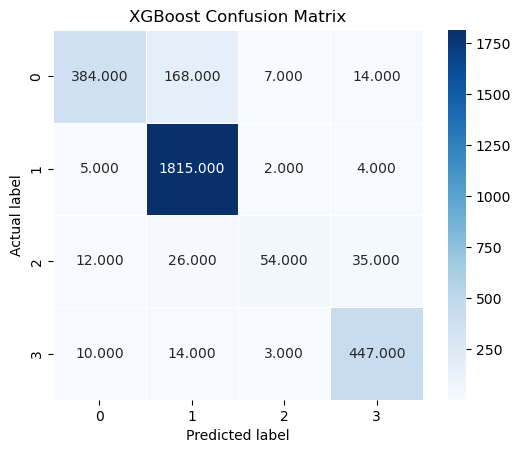


Decision Tree Metrics:
Accuracy: 0.961
Precision: 0.921
Recall: 0.878
F1 Score: 0.896


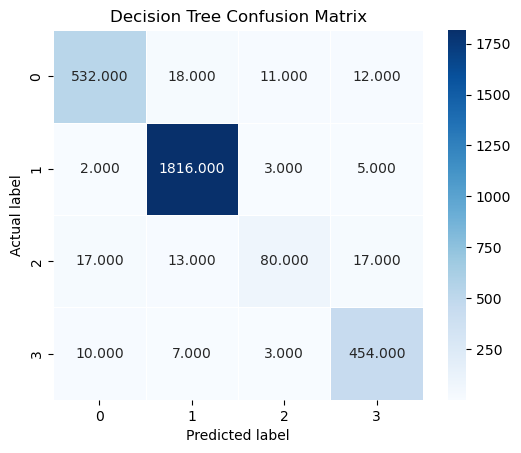


Random Forest Metrics:
Accuracy: 0.961
Precision: 0.921
Recall: 0.878
F1 Score: 0.896


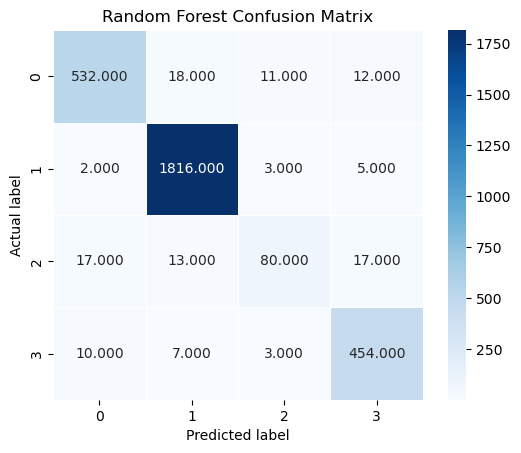

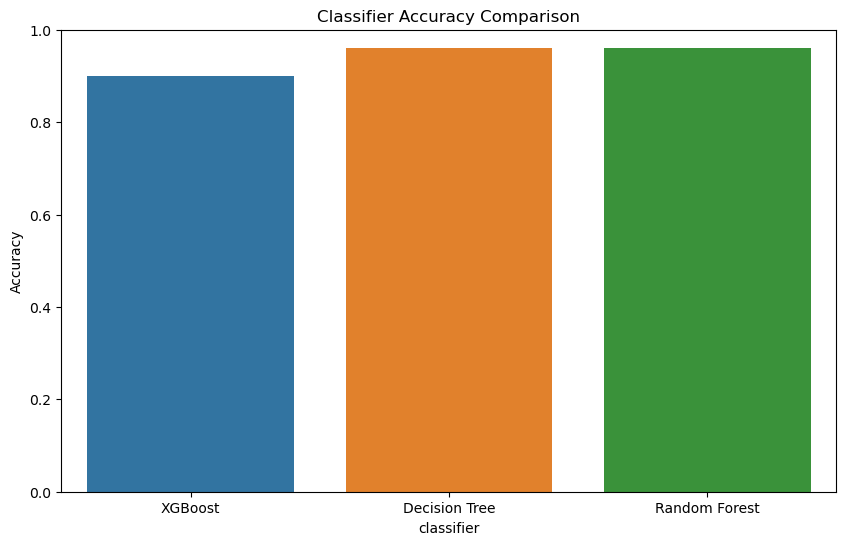

In [22]:
# Encode target labels into numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define classifiers
classifiers = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

results = []

# Evaluate each classifier
for name, classifier in classifiers.items():
    # Fit the model
    classifier.fit(X_train, y_train_encoded)
    
    # Predictions using the trained model
    y_pred_encoded = classifier.predict(X_test)
    
    # Convert back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Performance metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    results.append({'classifier': name, 'accuracy': accuracy})
    
    # Display metrics
    print(f"\n{name} Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    
    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

# Compare classifier accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x="classifier", y="accuracy", data=pd.DataFrame(results))
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Comparison")
plt.show()


I embarked on a feature engineering journey to enhance the predictive capabilities of the data. Recognizing the potential interplay between two vital attributes, 'smoker' and 'exerciser', I combined them to create a new feature. This amalgamation yielded four distinct possibilities:

Smoker and Exerciser
Smoker and Non-Exerciser
Non-Smoker and Exerciser
Non-Smoker and Non-Exerciser
To facilitate a seamless integration into machine learning models, I applied label encoding to these categories, converting them into numeric values. This transformation streamlined the dataset, ensuring that our models could harness the combined predictive power of the 'smoker' and 'exerciser' attributes.

Upon training various classifiers, it became evident that both the Decision Trees and Random Forest classifiers exhibited exemplary performance. Intriguingly, they yielded similar high accuracy scores, underscoring their robustness and effectiveness in predicting outcomes based on the enhanced dataset.